In [1]:
#Importing the libraries

import pandas as pd
import numpy as np
from datetime import datetime as DateTime
from copy import deepcopy
import plotnine as p9
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6

from statsmodels.tsa.stattools import adfuller  # the augmented Dickey-Fuller test to check for stationarity of time-series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA



In [505]:
# Loading the data

dataDir = "C:/Work/INSOFE/Study Material/My_Project"

dailyTempData = pd.read_csv("Delhi_Daily_Temp_1995-2019.csv") 

print(dailyTempData.head())
print()
print("Data Types: ")
print(dailyTempData.dtypes)

print("\n Shape of the dateset: ")
print(dailyTempData.shape)

   Month  Day  Year  Temperature
0      1    1  1995         50.7
1      1    2  1995         52.1
2      1    3  1995         53.8
3      1    4  1995         53.7
4      1    5  1995         54.5

Data Types: 
Month            int64
Day              int64
Year             int64
Temperature    float64
dtype: object

 Shape of the dateset: 
(8781, 4)


According to the datatypes, dailyTempData is not read as TS object as the data types are 'int' and 'floadt64'.

In [506]:
# padding zeros in Day and Month columns because pandas date interpretation requires leading zeros in the single digit entries for
# respective columns and 


def padZerosToNum(s):
    if len(str(s))<2:
        s = "0" + str(s)
    return s

dailyTempData["Month"] = dailyTempData["Month"].map(padZerosToNum)

dailyTempData["Day"] = dailyTempData["Day"].map(padZerosToNum)

# dailyTempData.head()


In [507]:
# Creating a new column "Date" and mapping "Days", "Month" and "Year" to it


dailyTempData["Date"] = dailyTempData["Day"].map(str) + "-" + dailyTempData["Month"].map(str) + "-" + dailyTempData["Year"].map(str)

# dailyTempData["Date"] = pd.to_datetime(dailyTempData["Date"])

dailyTempData["Date"] = pd.to_datetime(dailyTempData["Date"], format="%d-%m-%Y")

#del(dailyTempDataTS) 

dailyTempData.head()
#print(dailyTempData.dtypes)

,Month,Day,Year,Temperature,Date
0,01,01,1995,50.7,1995-01-01
1,01,02,1995,52.1,1995-01-02
2,01,03,1995,53.8,1995-01-03
3,01,04,1995,53.7,1995-01-04
4,01,05,1995,54.5,1995-01-05


In [508]:
# Encoding the weeks as well for exploratory analysis

dailyTempData["Week"] = dailyTempData.Date.dt.week

dailyTempData.head()

,Month,Day,Year,Temperature,Date,Week
0,01,01,1995,50.7,1995-01-01,52
1,01,02,1995,52.1,1995-01-02,1
2,01,03,1995,53.8,1995-01-03,1
3,01,04,1995,53.7,1995-01-04,1
4,01,05,1995,54.5,1995-01-05,1


In [509]:
# Preprocessing: Handling missing values
# There are several rows having temperature as "-99". Replacing -99 by NaNs and 

dailyTempData["Temperature"] = dailyTempData["Temperature"].replace(-99,np.NaN)
dailyTempData[dailyTempData["Temperature"].isnull()]

,Month,Day,Year,Temperature,Date,Week
87,03,29,1995,NaN,1995-03-29,13
1323,08,16,1998,NaN,1998-08-16,33
1369,10,01,1998,NaN,1998-10-01,40
1453,12,24,1998,NaN,1998-12-24,52
1454,12,25,1998,NaN,1998-12-25,52
1459,12,30,1998,NaN,1998-12-30,53
1460,12,31,1998,NaN,1998-12-31,53
1470,01,10,1999,NaN,1999-01-10,1
1579,04,29,1999,NaN,1999-04-29,17
1580,04,30,1999,NaN,1999-04-30,17


In [510]:
# Now replacing the null values using the its forward and backward neighbours

dailyTempData['Temperature_backFill'] = dailyTempData['Temperature'].fillna(method='bfill')
dailyTempData['Temperature_forwardFill'] = dailyTempData['Temperature'].fillna(method='ffill')

dailyTempData['Temperature'] = (dailyTempData['Temperature_backFill'] + dailyTempData['Temperature_forwardFill'])/2

print(dailyTempData.head())

#Dropping the extra columns
dailyTempData.drop(["Temperature_backFill","Temperature_forwardFill"], axis=1, inplace=True)
print("\n\n")
print("dailyTempData after dropping the extra temperature columns: \n" )
print(dailyTempData.head())

  Month Day  Year  Temperature       Date  Week  Temperature_backFill  \
0    01  01  1995         50.7 1995-01-01    52                  50.7   
1    01  02  1995         52.1 1995-01-02     1                  52.1   
2    01  03  1995         53.8 1995-01-03     1                  53.8   
3    01  04  1995         53.7 1995-01-04     1                  53.7   
4    01  05  1995         54.5 1995-01-05     1                  54.5   

   Temperature_forwardFill  
0                     50.7  
1                     52.1  
2                     53.8  
3                     53.7  
4                     54.5  



dailyTempData after dropping the extra temperature columns: 

  Month Day  Year  Temperature       Date  Week
0    01  01  1995         50.7 1995-01-01    52
1    01  02  1995         52.1 1995-01-02     1
2    01  03  1995         53.8 1995-01-03     1
3    01  04  1995         53.7 1995-01-04     1
4    01  05  1995         54.5 1995-01-05     1


In [511]:
#Creating a deep copy "dailyTempDataTS" of our dataset "dailyTempData".
# We will convert "dailyTempDataTS" into TS object

dailyTempDataTS = deepcopy(dailyTempData)
dailyTempDataTS.drop(["Day", "Month", "Year", "Week"], axis=1, inplace=True)
dailyTempDataTS.set_index(["Date"], inplace=True)

print("Null values in Temperature column: ")
print(dailyTempDataTS[dailyTempDataTS["Temperature"].isnull()])
pd.isnull(dailyTempDataTS).values.any() 

print("\n 'dailyTempDataTS' as TS object")
print(dailyTempDataTS.head())
print("Shape: "+ str(dailyTempDataTS.shape))

Null values in Temperature column: 
Empty DataFrame
Columns: [Temperature]
Index: []

 'dailyTempDataTS' as TS object
            Temperature
Date                   
1995-01-01         50.7
1995-01-02         52.1
1995-01-03         53.8
1995-01-04         53.7
1995-01-05         54.5
Shape: (8781, 1)


In [512]:
dailyTempDataTS.index

DatetimeIndex(['1995-01-01', '1995-01-02', '1995-01-03', '1995-01-04',
               '1995-01-05', '1995-01-06', '1995-01-07', '1995-01-08',
               '1995-01-09', '1995-01-10',
               ...
               '2019-01-06', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13',
               '2019-01-14', '2019-01-15'],
              dtype='datetime64[ns]', name='Date', length=8781, freq=None)

dtype=’datetime[ns]’ which confirms that it is a datetime object.

### Checking Stationarity of a Time Series

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. 
But why is it important? Most of the TS models work on the assumption that the TS is stationary. 

Intuitively, we can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:
    1. constant mean
    2. constant variance
    3. an autocovariance that does not depend on time.
    

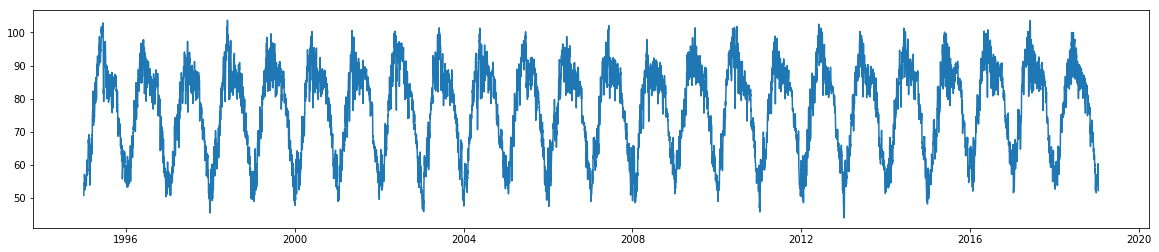

In [513]:
rcParams['figure.figsize'] = 20, 4

plt.plot(dailyTempDataTS)

We can check stationarity using the following:    
    
Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last x days. But again this is more of a visual technique

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [514]:
def test_stationarityTS_DF(timeseries, window_size=30):
    ## The window size is related to the time resolutiuon of our input.
    # in the current dataset, we have daily data, hence the window_size number will correspond to days
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# use this version of the function if you are inputting a Pandas Series object. 
# For example, the "residuals" from the output of the seasonal_decomposition function
def test_stationarityTS_Series(timeseries, window_size=30):
    
    ## The window size is related to the time resolutiuon of our input.
    # in the current dataset, we have daily data, hence the window_size number will correspond to days
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

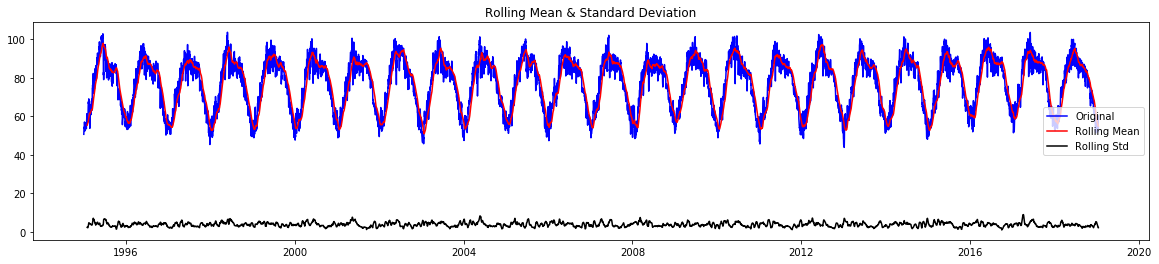

Results of Dickey-Fuller Test:
Test Statistic                -8.446546e+00
p-value                        1.706710e-13
#Lags Used                     3.700000e+01
Number of Observations Used    8.743000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [515]:
test_stationarityTS_DF(dailyTempDataTS)

Recall: null hypothesis is that the TS is non-stationary

The variation in standard deviation is small, 30 day rolling mean is not increasing with time. 
Also, notice that the test statistic is much less than the critical values. Hence, we can reject the Null hypothesis
Thus, this is a stationary series when all the observations are considered (i.e., for all the years).  
(Note that the signed values should be compared and not the absolute values.)

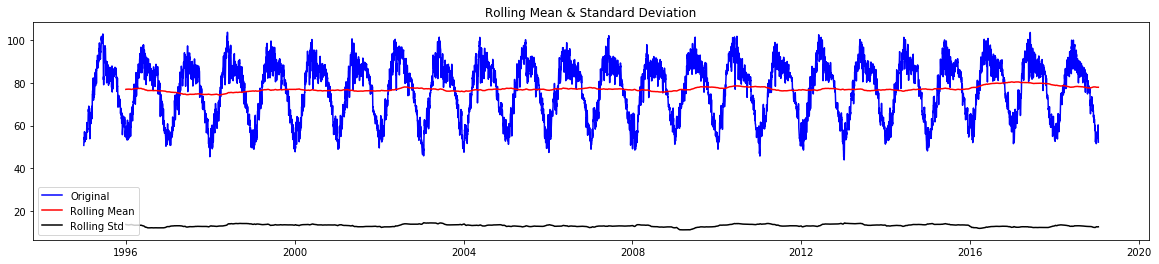

Results of Dickey-Fuller Test:
Test Statistic                -8.446546e+00
p-value                        1.706710e-13
#Lags Used                     3.700000e+01
Number of Observations Used    8.743000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [516]:
# Checking how annual rolling means look like
test_stationarityTS_DF(dailyTempDataTS, window_size=365)

As we can see the 365 days rolling means is almost flat at approximately 80 deg F and the series is more-or-less stationary, we need to consider subsetting some years of data and checking the stationarity of those subsets 

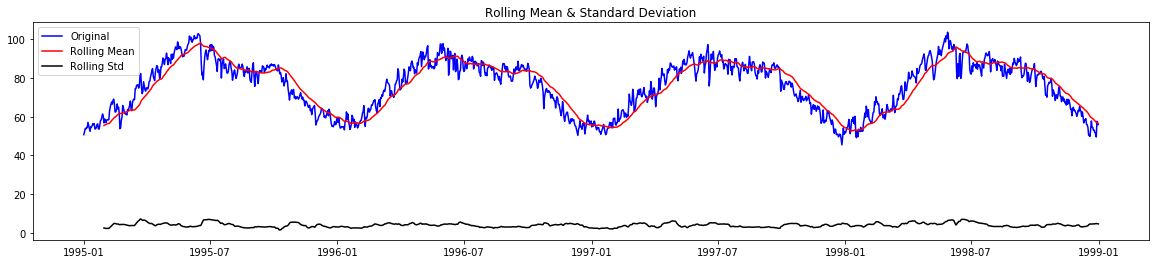

Results of Dickey-Fuller Test:
Test Statistic                   -2.012549
p-value                           0.281098
#Lags Used                       12.000000
Number of Observations Used    1448.000000
Critical Value (1%)              -3.434874
Critical Value (5%)              -2.863538
Critical Value (10%)             -2.567834
dtype: float64


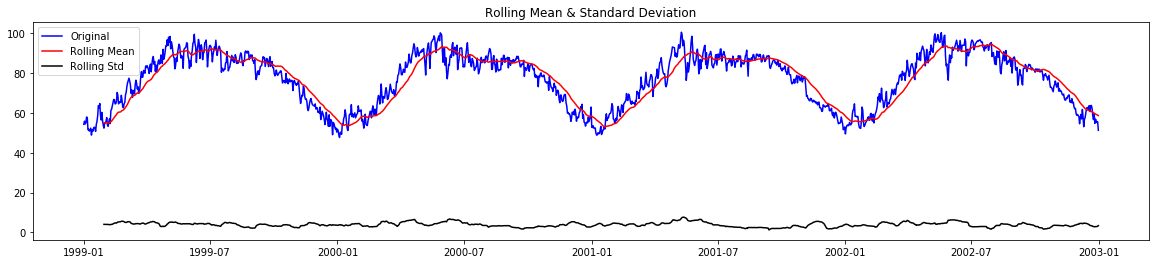

Results of Dickey-Fuller Test:
Test Statistic                   -2.211566
p-value                           0.202075
#Lags Used                        8.000000
Number of Observations Used    1452.000000
Critical Value (1%)              -3.434862
Critical Value (5%)              -2.863533
Critical Value (10%)             -2.567831
dtype: float64


In [517]:
# Subsetting the data for every four years (discarding 2019)

dailyTempDataTS_1995to2018 = dailyTempDataTS["1995":"2018"] 

test_stationarityTS_DF(dailyTempDataTS_1995to2018["1995":"1998"])
test_stationarityTS_DF(dailyTempDataTS_1995to2018["1999":"2002"])


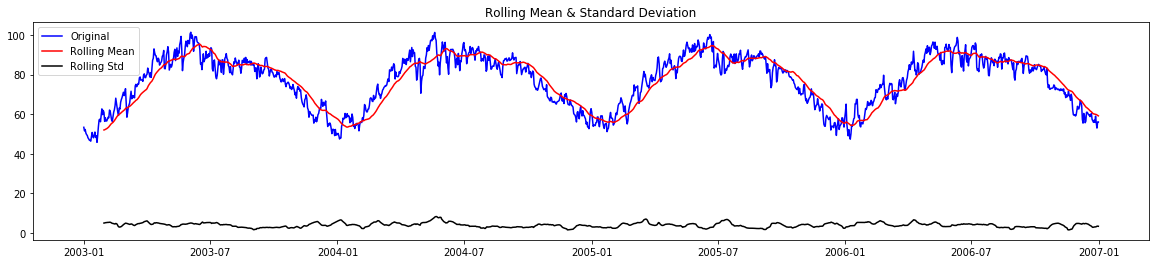

Results of Dickey-Fuller Test:
Test Statistic                   -2.477872
p-value                           0.120951
#Lags Used                        9.000000
Number of Observations Used    1451.000000
Critical Value (1%)              -3.434865
Critical Value (5%)              -2.863534
Critical Value (10%)             -2.567832
dtype: float64


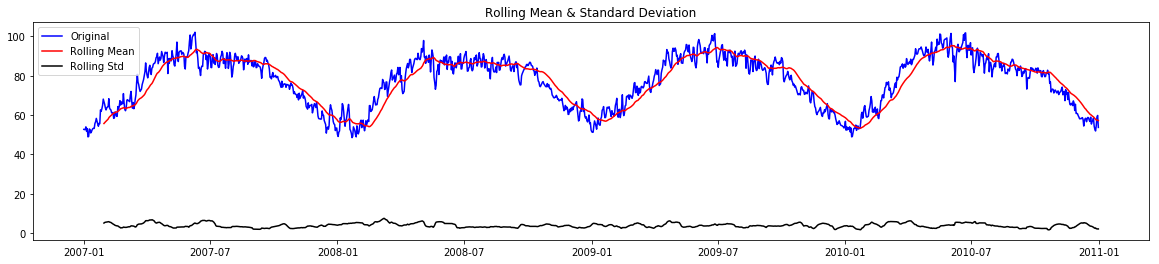

Results of Dickey-Fuller Test:
Test Statistic                   -2.277636
p-value                           0.179282
#Lags Used                        7.000000
Number of Observations Used    1453.000000
Critical Value (1%)              -3.434859
Critical Value (5%)              -2.863531
Critical Value (10%)             -2.567830
dtype: float64


In [518]:
test_stationarityTS_DF(dailyTempDataTS_1995to2018["2003":"2006"])
test_stationarityTS_DF(dailyTempDataTS_1995to2018["2007":"2010"])

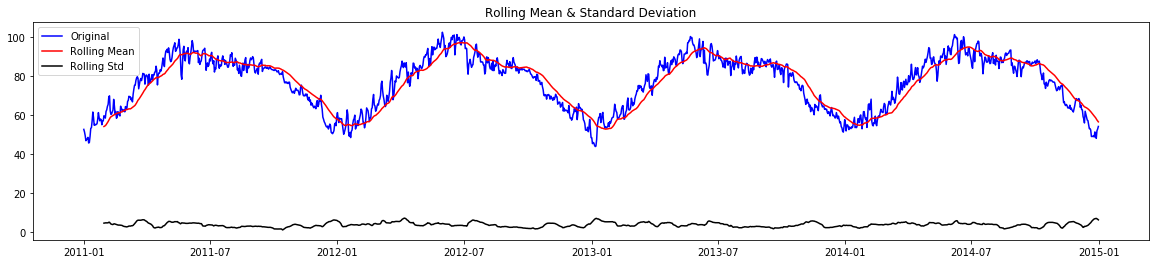

Results of Dickey-Fuller Test:
Test Statistic                   -2.301666
p-value                           0.171431
#Lags Used                        6.000000
Number of Observations Used    1454.000000
Critical Value (1%)              -3.434855
Critical Value (5%)              -2.863530
Critical Value (10%)             -2.567829
dtype: float64


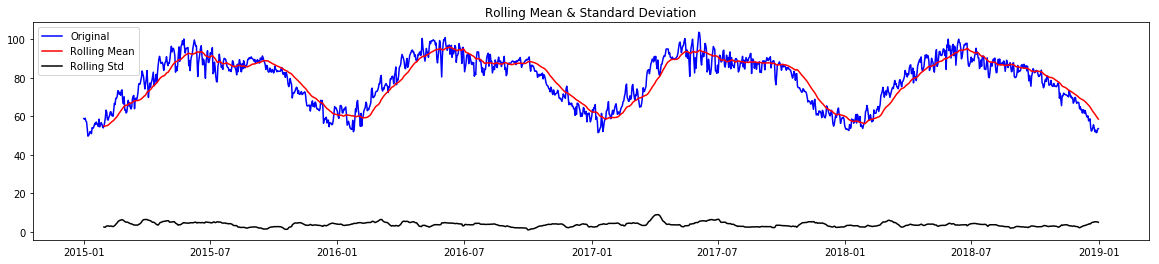

Results of Dickey-Fuller Test:
Test Statistic                   -2.118886
p-value                           0.236989
#Lags Used                        8.000000
Number of Observations Used    1452.000000
Critical Value (1%)              -3.434862
Critical Value (5%)              -2.863533
Critical Value (10%)             -2.567831
dtype: float64


In [519]:
test_stationarityTS_DF(dailyTempDataTS_1995to2018["2011":"2014"])
test_stationarityTS_DF(dailyTempDataTS_1995to2018["2015":"2018"])

On subsetting the data every four years, the 30 day rolling means as well as the results of the Dickey-Fuller Tests shows non-stationarity 

(For 30 day rolling means notice that there is year to year as well as within year pattern)


### Making a Time Series Stationary

As forecasting is easier on a stationary data, making our data stationary 

Main reasons behind non-stationarity of a TS:
1. Trend – varying mean over time. In our case, for every year the temperature varies as per the month.
2. Seasonality – variations at specific time-frames. In our case, there are repeating patterns around similar timeframes for all the years  

Our goal is to
    1. model the trend and seasonality in the series 
    2. remove the trend and seasonality from the series to get a stationary series
    3. implement statistical forecasting techniques on this stationary series
    4. convert the forecasted values into the original scale by applying trend and seasonality back.

#### Lets start with the standard approach used for time series modeling

1. Decomposing the time series into its components
2. Extract the residuals 
3. Check the stationarity of the residuals 
4. Plot the ACF and PACF of the residuals and infer the order of the ARIMA model (i.e., p,d,q parameters of ARIMA)
5. Model the residuals as an ARIMA process with the chosen p,d,q
6. Run diagnostics on the fitted ARIMA model. Namely, constant mean and variance as well as the residuals of the fitted model should be i.i.d. i.e. white noise


##### Step 1: Decomposing the time series into its components
##### and
##### Step 2: Extract the residuals

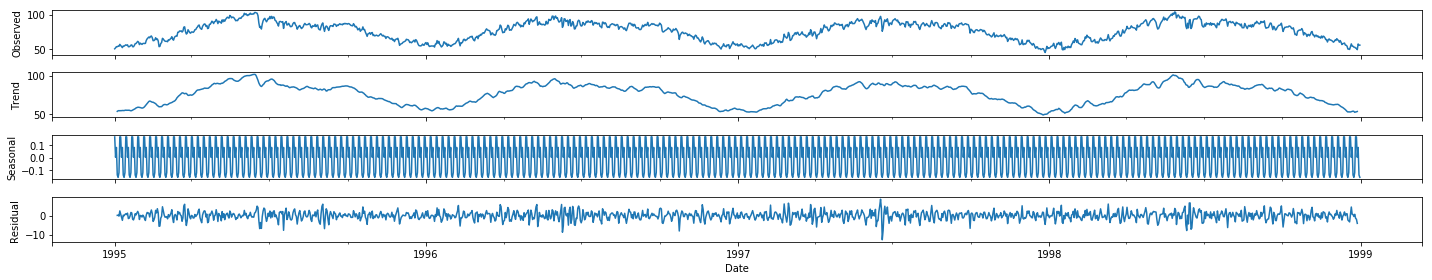

In [520]:
dailyTempDataTS_1995to1998 = dailyTempDataTS_1995to2018["1995":"1998"]

decomp_1995to1998 = seasonal_decompose(dailyTempDataTS_1995to1998)

decomp_1995to1998plot = decomp_1995to1998.plot()

trend_1995to1998 = decomp_1995to1998.trend
seasonal_1995to1998 = decomp_1995to1998.seasonal
residual_1995to1998 = decomp_1995to1998.resid


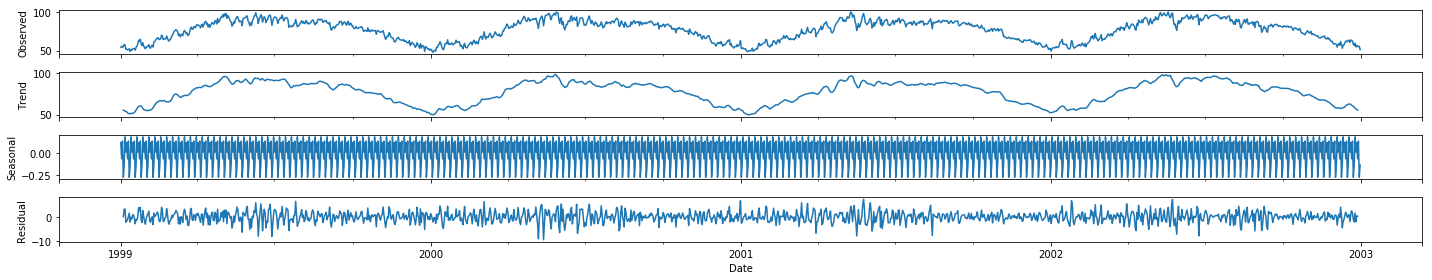

In [521]:
dailyTempDataTS_1999to2002 = dailyTempDataTS_1995to2018["1999":"2002"]

decomp_1999to2002 = seasonal_decompose(dailyTempDataTS_1999to2002)

decomp_1999to2002plot = decomp_1999to2002.plot()

trend_1999to2002 = decomp_1999to2002.trend
seasonal_1999to2002 = decomp_1999to2002.seasonal
residual_1999to2002 = decomp_1999to2002.resid

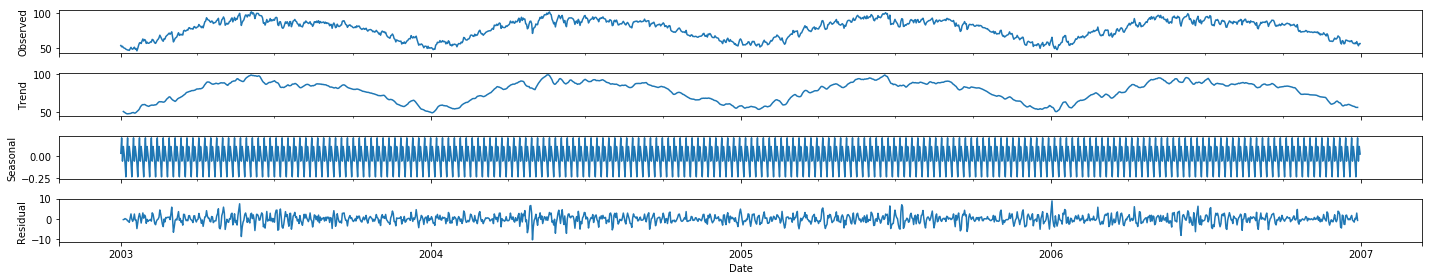

In [522]:
dailyTempDataTS_2003to2006 = dailyTempDataTS_1995to2018["2003":"2006"]

decomp_2003to2006 = seasonal_decompose(dailyTempDataTS_2003to2006)

decomp_2003to2006plot = decomp_2003to2006.plot()

trend_2003to2006 = decomp_2003to2006.trend
seasonal_2003to2006 = decomp_2003to2006.seasonal
residual_2003to2006 = decomp_2003to2006.resid

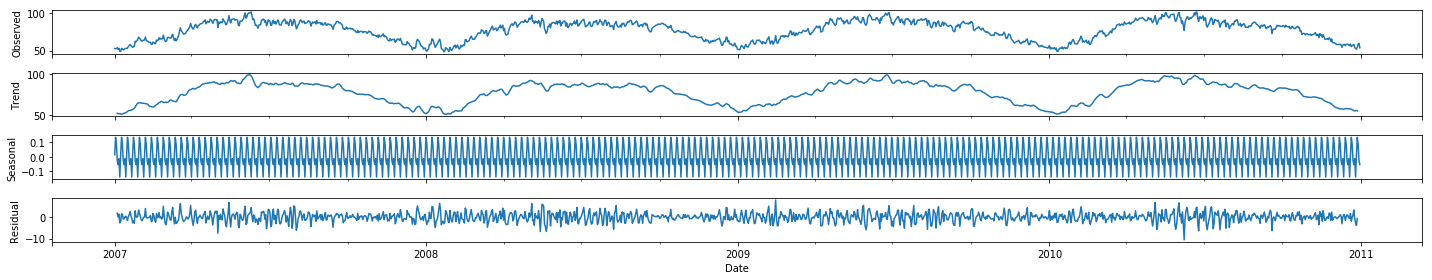

In [523]:
dailyTempDataTS_2007to2010 = dailyTempDataTS_1995to2018["2007":"2010"]

decomp_2007to2010 = seasonal_decompose(dailyTempDataTS_2007to2010)

decomp_2007to2010plot = decomp_2007to2010.plot()

trend_2007to2010 = decomp_2007to2010.trend
seasonal_2007to2010 = decomp_2007to2010.seasonal
residual_2007to2010 = decomp_2007to2010.resid

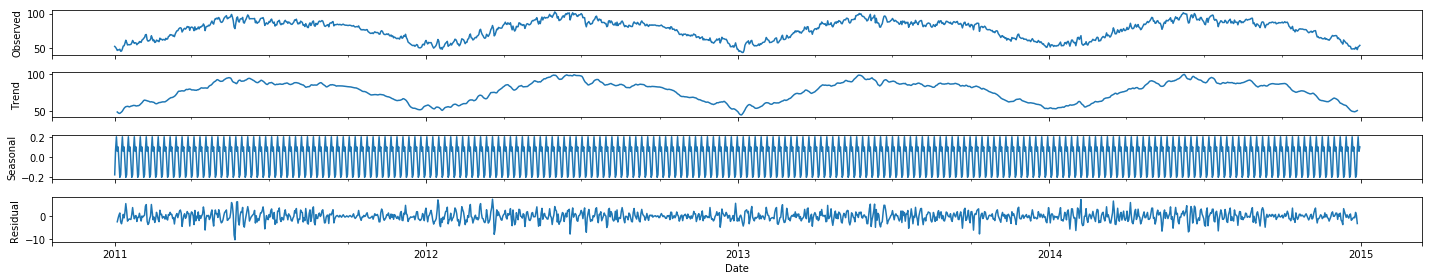

In [524]:
dailyTempDataTS_2011to2014 = dailyTempDataTS_1995to2018["2011":"2014"]

decomp_2011to2014 = seasonal_decompose(dailyTempDataTS_2011to2014)

decomp_2011to2014plot = decomp_2011to2014.plot()

trend_2011to2014 = decomp_2011to2014.trend
seasonal_2011to2014 = decomp_2011to2014.seasonal
residual_2011to2014 = decomp_2011to2014.resid

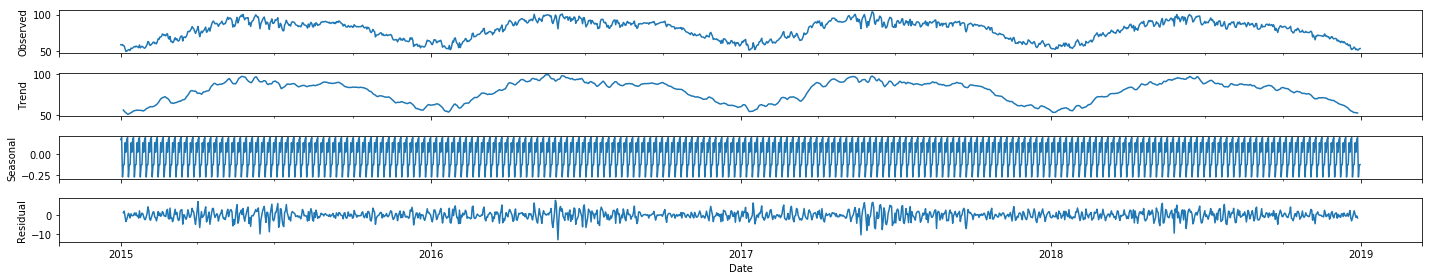

In [525]:
dailyTempDataTS_2015to2018 = dailyTempDataTS_1995to2018["2015":"2018"]

decomp_2015to2018 = seasonal_decompose(dailyTempDataTS_2015to2018)

decomp_2015to2018plot = decomp_2015to2018.plot()

trend_2015to2018 = decomp_2015to2018.trend
seasonal_2015to2018 = decomp_2015to2018.seasonal
residual_2015to2018 = decomp_2015to2018.resid

##### Step 3: Check the stationarity of the residuals

As the trend and sesonality for every subset has been seperated, checking the stationarity of residuals

Temperature    6
dtype: int64


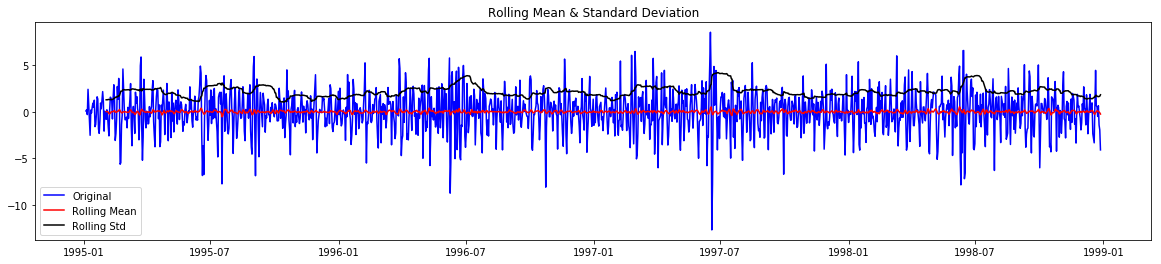

Results of Dickey-Fuller Test:
Test Statistic                -1.467893e+01
p-value                        3.178826e-27
#Lags Used                     2.300000e+01
Number of Observations Used    1.431000e+03
Critical Value (1%)           -3.434928e+00
Critical Value (5%)           -2.863562e+00
Critical Value (10%)          -2.567846e+00
dtype: float64


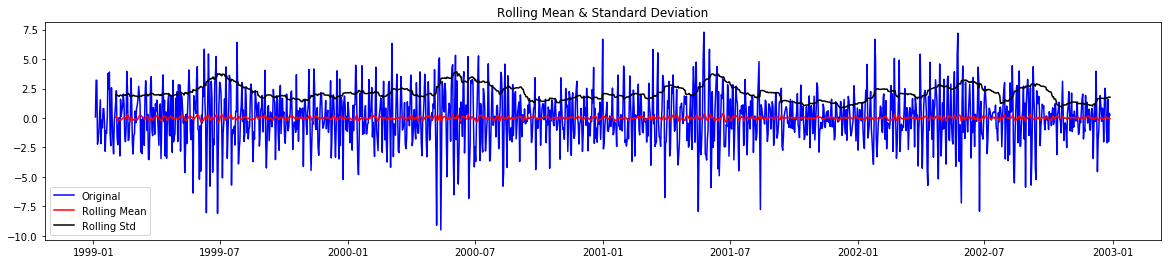

Results of Dickey-Fuller Test:
Test Statistic                -1.457803e+01
p-value                        4.515585e-27
#Lags Used                     2.400000e+01
Number of Observations Used    1.430000e+03
Critical Value (1%)           -3.434931e+00
Critical Value (5%)           -2.863563e+00
Critical Value (10%)          -2.567847e+00
dtype: float64


In [526]:
print(residual_1995to1998.isnull().sum())
residual_1995to1998.dropna(inplace=True)
test_stationarityTS_DF(residual_1995to1998)

#print(residual_1999to2002.isnull().sum()
residual_1999to2002.dropna(inplace=True)
test_stationarityTS_DF(residual_1999to2002)

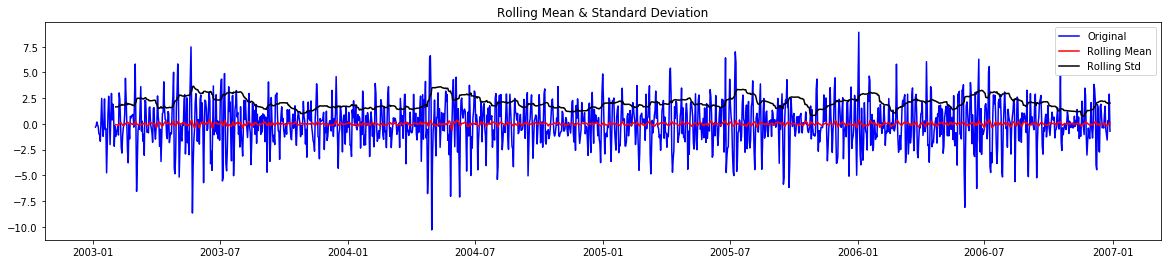

Results of Dickey-Fuller Test:
Test Statistic                -1.440060e+01
p-value                        8.521705e-27
#Lags Used                     2.400000e+01
Number of Observations Used    1.430000e+03
Critical Value (1%)           -3.434931e+00
Critical Value (5%)           -2.863563e+00
Critical Value (10%)          -2.567847e+00
dtype: float64


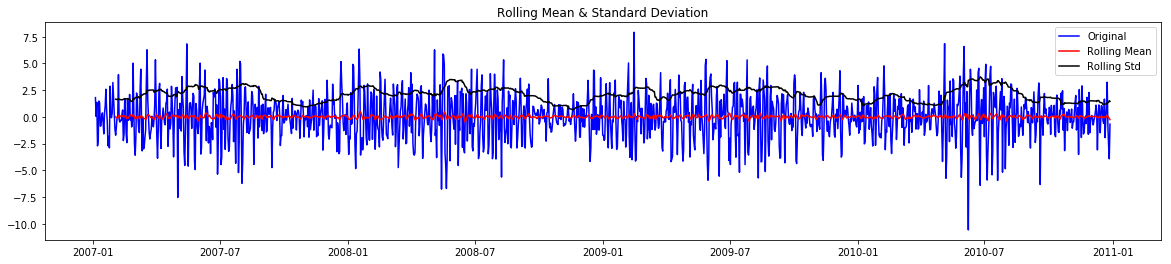

Results of Dickey-Fuller Test:
Test Statistic                -1.476265e+01
p-value                        2.389066e-27
#Lags Used                     2.400000e+01
Number of Observations Used    1.430000e+03
Critical Value (1%)           -3.434931e+00
Critical Value (5%)           -2.863563e+00
Critical Value (10%)          -2.567847e+00
dtype: float64


In [527]:
#print(residual_2003to2006.isnull().sum())
residual_2003to2006.dropna(inplace=True)
test_stationarityTS_DF(residual_2003to2006)

#print(residual_2007to2010.isnull().sum())
residual_2007to2010.dropna(inplace=True)
test_stationarityTS_DF(residual_2007to2010)

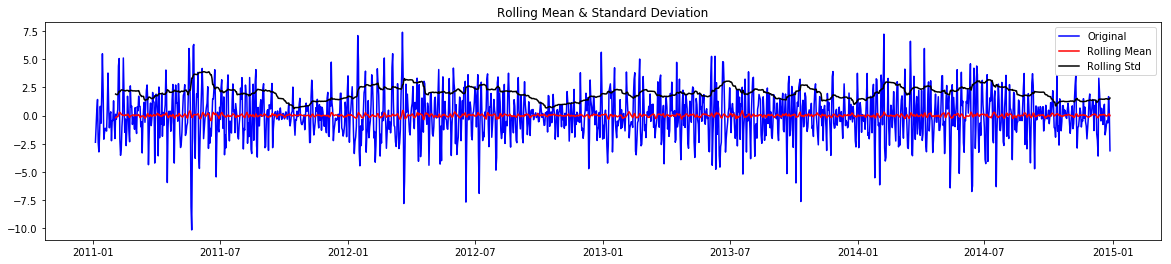

Results of Dickey-Fuller Test:
Test Statistic                -1.374486e+01
p-value                        1.077299e-25
#Lags Used                     2.400000e+01
Number of Observations Used    1.430000e+03
Critical Value (1%)           -3.434931e+00
Critical Value (5%)           -2.863563e+00
Critical Value (10%)          -2.567847e+00
dtype: float64


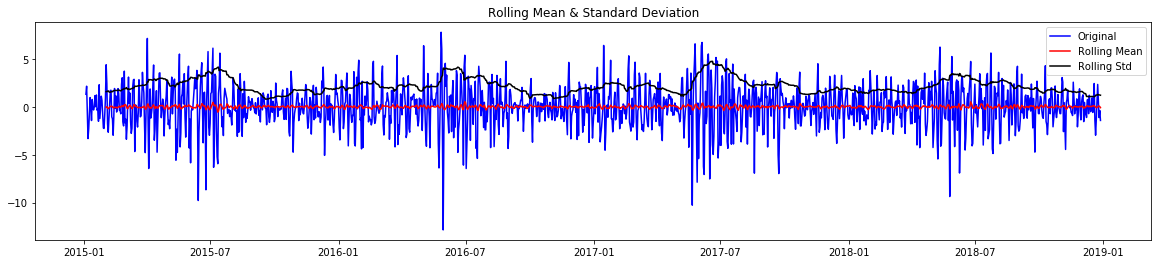

Results of Dickey-Fuller Test:
Test Statistic                -1.515755e+01
p-value                        6.661398e-28
#Lags Used                     2.300000e+01
Number of Observations Used    1.431000e+03
Critical Value (1%)           -3.434928e+00
Critical Value (5%)           -2.863562e+00
Critical Value (10%)          -2.567846e+00
dtype: float64


In [528]:
#print(residual_2011to2014.isnull().sum())
residual_2011to2014.dropna(inplace=True)
test_stationarityTS_DF(residual_2011to2014)

#print(residual_2015to2018.isnull().sum())
residual_2015to2018.dropna(inplace=True)
test_stationarityTS_DF(residual_2015to2018)

Dickey-Fuller test statistic is significantly lower than the 1% critical value for all the subsets.

Recall: null hypothesis is that the TS is non-stationary

Therefore, the NULL hypothesis can be rejected which means all the subsets are very close to stationary

##### Step 4: Plot the ACF and PACF of the residuals and infer the order of the ARIMA model (i.e., p,d,q parameters of ARIMA)

##### Step 5: Model the residuals as an ARIMA process with the chosen p,d,q


After performeing the trend and seasonality estimation, there can be two situations:

    a. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the      residuals as white noise. But this is very rare.

    b. A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to  forecast the data.
    

**ARIMA** stands for Auto-Regressive Integrated Moving Averages. 
The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:


**Number of AR (Auto-Regressive) terms (p)**: AR terms are just **lags of dependent variable**. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

**Number of MA (Moving Average) terms (q)**: MA terms are **lagged forecast errors in prediction equation**. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Number of Differences (d)**: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.


An importance concern here is how to determine the value of ‘p’ and ‘q’.

**Autocorrelation Function (ACF)**: nth lag of ACF is the correlation between a day and n days before that

**Partial Autocorrelation Function (PACF)**: The same as ACF with all intermediate correlations removed. It is the kth coefficient of the ordinary least squares regression. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

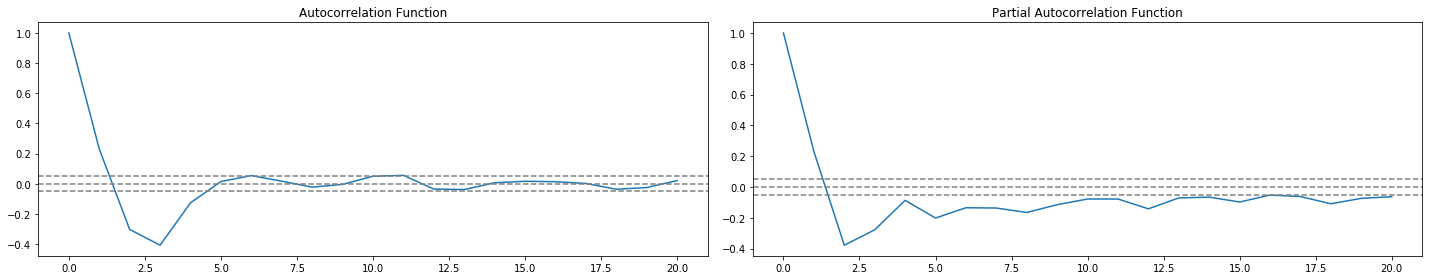

In [529]:
lag_acf = acf(residual_1995to1998, nlags=20)
lag_pacf = pacf(residual_1995to1998, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_1995to1998)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_1995to1998)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_1995to1998)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_1995to1998)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()



The two dotted lines on either sides of 0 are the confidence interevals can be used to determine the ‘p’ and ‘q’ values as:

**p** – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.

**q** – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

In [530]:
#residual_1995to1998

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 4293.7365')

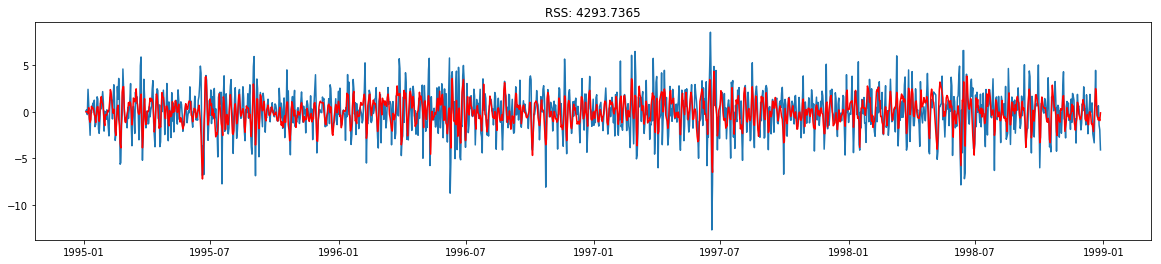

In [531]:
model_1995to1998 = ARIMA(residual_1995to1998, order=(2, 0, 2))  
results_ARMA_1995to1998 = model_1995to1998.fit(disp=-1)  
plt.plot(residual_1995to1998)
plt.plot(results_ARMA_1995to1998.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARMA_1995to1998.fittedvalues-residual_1995to1998.Temperature)**2))

##### Taking the fitted values back to original scale

In [532]:
predictions_ARMA_1995to1998 = pd.Series(results_ARMA_1995to1998.fittedvalues, copy=True)
print(predictions_ARMA_1995to1998.head())
print()
print(predictions_ARMA_1995to1998.tail())

Date
1995-01-04    0.000238
1995-01-05    0.021597
1995-01-06    0.032451
1995-01-07   -0.151241
1995-01-08    0.450080
dtype: float64

Date
1998-12-24   -0.643401
1998-12-25   -0.890577
1998-12-26   -0.638447
1998-12-27   -0.946444
1998-12-28   -0.107934
dtype: float64


Pad zeros to start and end of the predictions to make its length equal to that of the original series

In [533]:
# predictions_ARMA[0:2] = 0
# predictions_ARMA[-2:] = 0
# print(predictions_ARMA.head())
# print()
# print(predictions_ARMA.tail())
# print(len(predictions_ARMA))
# print(len(dailyTempDataTS_1995to1998))

            Temp_res  Temp_Trend  Temp_Seas       Temp
Date                                                  
1995-01-01  0.000000   53.742857   0.162324  53.905182
1995-01-02  0.000000   53.742857   0.002675  53.745532
1995-01-03  0.000000   53.742857   0.079831  53.822688
1995-01-04  0.000238   53.742857  -0.135787  53.607308
1995-01-05  0.021597   54.442857  -0.154537  54.309917
1995-01-06  0.032451   54.714286  -0.117895  54.628841
1995-01-07 -0.151241   54.514286   0.163389  54.526433
1995-01-08  0.450080   54.671429   0.162324  55.283834
1995-01-09 -0.815391   54.671429   0.002675  53.858712
1995-01-10 -1.119626   54.842857   0.079831  53.803062
1995-01-11 -0.833566   54.742857  -0.135787  53.773505
1995-01-12  0.596321   54.771429  -0.154537  55.213213
1995-01-13  0.367748   55.114286  -0.117895  55.364138
1995-01-14  0.431320   55.300000   0.163389  55.894709
1995-01-15  0.170103   55.142857   0.162324  55.475284
1995-01-16 -0.307108   55.142857   0.002675  54.838424
1995-01-17

Text(0.5, 1.0, 'RMSE: 1.7225')

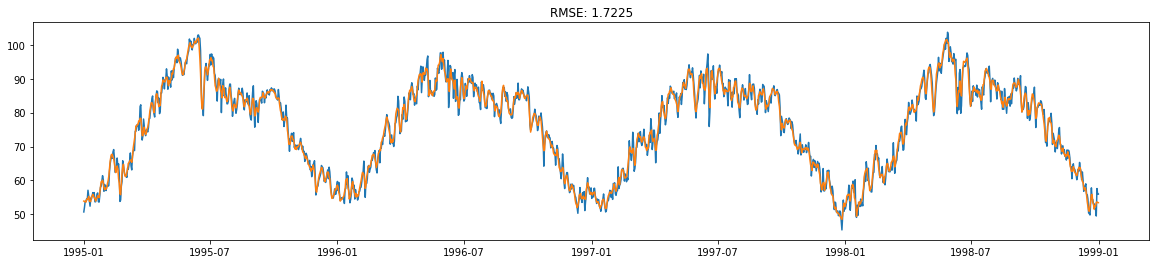

In [534]:
# print(len(dailyTempDataTS_1995to1998))
# print(len(trend_1995to1998))
# print(len(seasonal_1995to1998))
# print(len(predictions_ARMA))

dates_1995to1998 = dailyTempDataTS_1995to1998.index.values
myzeros_1995to1998 = np.zeros(len(dailyTempDataTS_1995to1998))
pred_ARMA_DF_1995to1998 = pd.DataFrame(myzeros_1995to1998,index=dates_1995to1998)
# predictions_ARMA.columns = "Col"
# pred_ARMA_DF.join(pd.DataFrame(predictions_ARMA))
predictions_ARMA_new_1995to1998 = pd.merge(pred_ARMA_DF_1995to1998, pd.DataFrame(predictions_ARMA_1995to1998) , left_index=True, right_index= True,how='left').replace(np.NaN,0)
predictions_ARMA_new_1995to1998["value"] = predictions_ARMA_new_1995to1998['0_x'] + predictions_ARMA_new_1995to1998['0_y']
predictions_ARMA_new_1995to1998.drop(['0_x', '0_y'], inplace=True, axis=1)
#predictions_ARMA_new_1995to1998


new_1995to1998 = pd.concat([predictions_ARMA_new_1995to1998,trend_1995to1998,seasonal_1995to1998], axis=1)
new_1995to1998.columns = ["Temp_res", "Temp_Trend", "Temp_Seas"]
new_1995to1998["Temp_Trend"] = new_1995to1998["Temp_Trend"].replace(np.nan,0)
new_1995to1998["Temp_Trend"][0:3] = new_1995to1998["Temp_Trend"][3]
new_1995to1998["Temp_Trend"][-3:] = new_1995to1998["Temp_Trend"][-4]
new_1995to1998["Temp"] = new_1995to1998["Temp_res"] + new_1995to1998["Temp_Trend"] + new_1995to1998["Temp_Seas"]
print(new_1995to1998)



plt.plot(dailyTempDataTS_1995to1998)
plt.plot(new_1995to1998.Temp)
plt.title('RMSE: %.4f'% np.sqrt(sum((new_1995to1998.Temp-dailyTempDataTS_1995to1998.Temperature)**2)/len(dailyTempDataTS_1995to1998.Temperature)))

Repeting Step 4 and 5 for subset 1999_2002

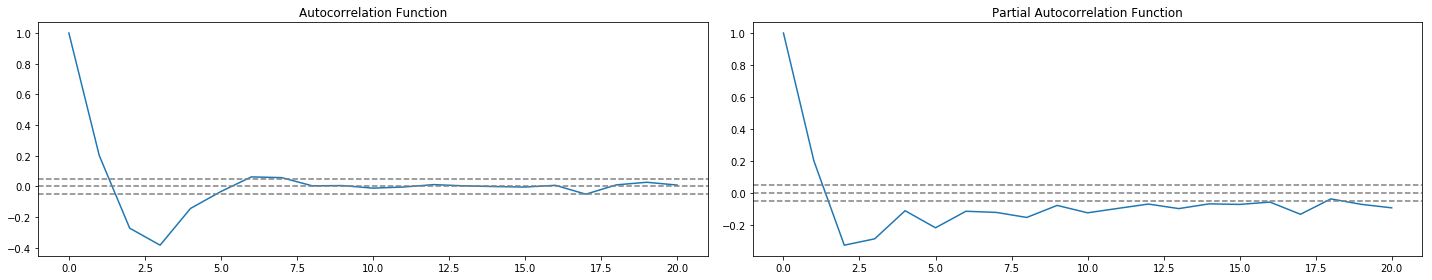

In [535]:
lag_acf = acf(residual_1999to2002, nlags=20)
lag_pacf = pacf(residual_1999to2002, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_1999to2002)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_1999to2002)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_1999to2002)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_1999to2002)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 4421.3799')

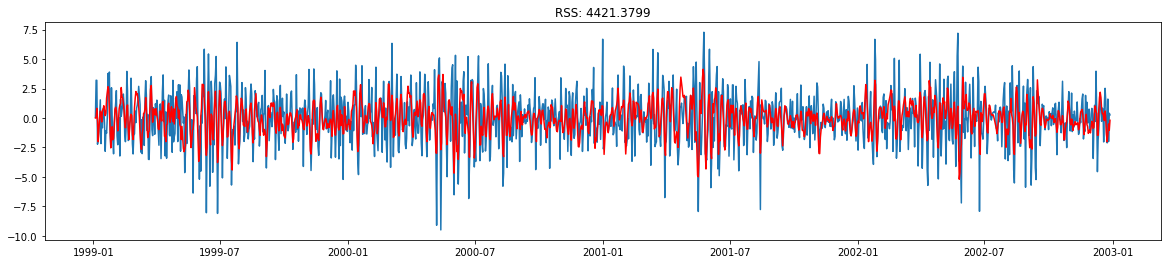

In [536]:
model_1999to2002 = ARIMA(residual_1999to2002, order=(2, 0, 2))  
results_ARMA_1999to2002 = model_1999to2002.fit(disp=-1)  
plt.plot(residual_1999to2002)
plt.plot(results_ARMA_1999to2002.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARMA_1999to2002.fittedvalues-residual_1999to2002.Temperature)**2))

Text(0.5, 1.0, 'RMSE: 1.7436')

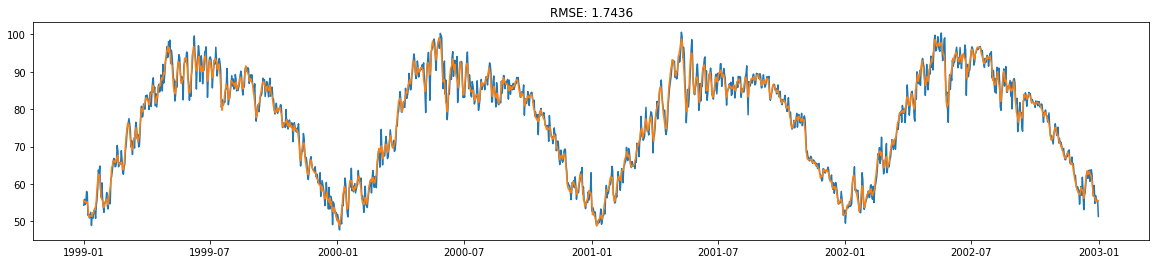

In [537]:
#Taking back the fitted values to the original scale 

predictions_ARMA_1999to2002 = pd.Series(results_ARMA_1999to2002.fittedvalues, copy=True)
# print(predictions_ARMA_1999to2002.head())
# print()
# print(predictions_ARMA_1999to2002.tail())

# print(len(dailyTempDataTS_1995to1998))
# print(len(trend_1995to1998))
# print(len(seasonal_1995to1998))
# print(len(predictions_ARMA))

dates_1999to2002 = dailyTempDataTS_1999to2002.index.values
myzeros_1999to2002 = np.zeros(len(dailyTempDataTS_1999to2002))
pred_ARMA_DF_1999to2002 = pd.DataFrame(myzeros_1999to2002,index=dates_1999to2002)

predictions_ARMA_new_1999to2002 = pd.merge(pred_ARMA_DF_1999to2002, pd.DataFrame(predictions_ARMA_1999to2002) , left_index=True, right_index= True,how='left').replace(np.NaN,0)
predictions_ARMA_new_1999to2002["value"] = predictions_ARMA_new_1999to2002['0_x'] + predictions_ARMA_new_1999to2002['0_y']
predictions_ARMA_new_1999to2002.drop(['0_x', '0_y'], inplace=True, axis=1)
#print(predictions_ARMA_new_1999to2002)


new_1999to2002 = pd.concat([predictions_ARMA_new_1999to2002,trend_1999to2002,seasonal_1999to2002], axis=1)
new_1999to2002.columns = ["Temp_res", "Temp_Trend", "Temp_Seas"]
new_1999to2002["Temp_Trend"] = new_1999to2002["Temp_Trend"].replace(np.nan,0)
new_1999to2002["Temp_Trend"][0:3] = new_1999to2002["Temp_Trend"][3]
new_1999to2002["Temp_Trend"][-3:] = new_1999to2002["Temp_Trend"][-4]
new_1999to2002["Temp"] = new_1999to2002["Temp_res"] + new_1999to2002["Temp_Trend"] + new_1999to2002["Temp_Seas"]
#print(new_1999to2002)



plt.plot(dailyTempDataTS_1999to2002)
plt.plot(new_1999to2002.Temp)
plt.title('RMSE: %.4f'% np.sqrt(sum((new_1999to2002.Temp-dailyTempDataTS_1999to2002.Temperature)**2)/len(dailyTempDataTS_1999to2002.Temperature)))

Repeting Step 4 and 5 for subset 2003_2006

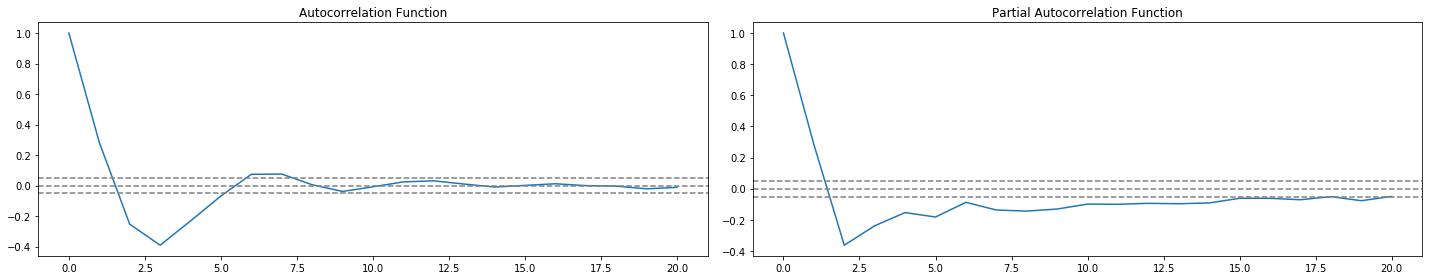

In [538]:
lag_acf = acf(residual_2003to2006, nlags=20)
lag_pacf = pacf(residual_2003to2006, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_2003to2006)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_2003to2006)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_2003to2006)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_2003to2006)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 3884.8411')

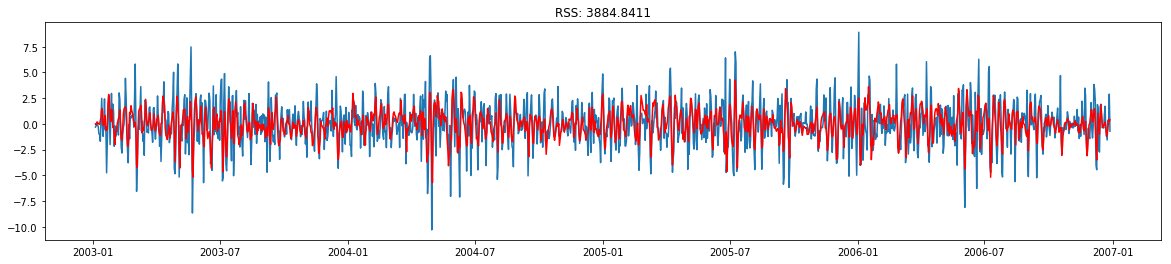

In [539]:
model_2003to2006 = ARIMA(residual_2003to2006, order=(2, 0, 2))  
results_ARMA_2003to2006 = model_2003to2006.fit(disp=-1)  
plt.plot(residual_2003to2006)
plt.plot(results_ARMA_2003to2006.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARMA_2003to2006.fittedvalues-residual_2003to2006.Temperature)**2))

Text(0.5, 1.0, 'RMSE: 1.6348')

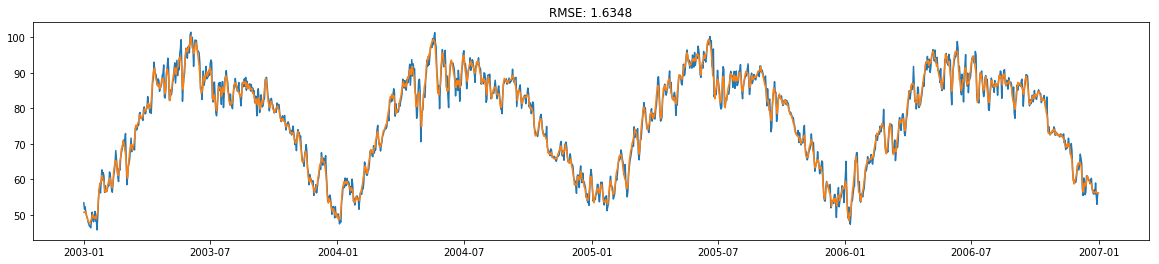

In [540]:
#Taking back the fitted values to the original scale 

predictions_ARMA_2003to2006 = pd.Series(results_ARMA_2003to2006.fittedvalues, copy=True)
# print(predictions_ARMA_2003to2006.head())
# print()
# print(predictions_ARMA_2003to2006.tail())

# print(len(dailyTempDataTS_2003to2006))
# print(len(trend_2003to2006))
# print(len(seasonal_2003to2006))
# print(len(predictions_ARMA))

dates_2003to2006 = dailyTempDataTS_2003to2006.index.values
myzeros_2003to2006 = np.zeros(len(dailyTempDataTS_2003to2006))
pred_ARMA_DF_2003to2006 = pd.DataFrame(myzeros_2003to2006,index=dates_2003to2006)

predictions_ARMA_new_2003to2006 = pd.merge(pred_ARMA_DF_2003to2006, pd.DataFrame(predictions_ARMA_2003to2006) , left_index=True, right_index= True,how='left').replace(np.NaN,0)
predictions_ARMA_new_2003to2006["value"] = predictions_ARMA_new_2003to2006['0_x'] + predictions_ARMA_new_2003to2006['0_y']
predictions_ARMA_new_2003to2006.drop(['0_x', '0_y'], inplace=True, axis=1)
#print(predictions_ARMA_new_2003to2006)


new_2003to2006 = pd.concat([predictions_ARMA_new_2003to2006,trend_2003to2006,seasonal_2003to2006], axis=1)
new_2003to2006.columns = ["Temp_res", "Temp_Trend", "Temp_Seas"]
new_2003to2006["Temp_Trend"] = new_2003to2006["Temp_Trend"].replace(np.nan,0)
new_2003to2006["Temp_Trend"][0:3] = new_2003to2006["Temp_Trend"][3]
new_2003to2006["Temp_Trend"][-3:] = new_2003to2006["Temp_Trend"][-4]
new_2003to2006["Temp"] = new_2003to2006["Temp_res"] + new_2003to2006["Temp_Trend"] + new_2003to2006["Temp_Seas"]
#print(new_2003to2006)



plt.plot(dailyTempDataTS_2003to2006)
plt.plot(new_2003to2006.Temp)
plt.title('RMSE: %.4f'% np.sqrt(sum((new_2003to2006.Temp-dailyTempDataTS_2003to2006.Temperature)**2)/len(dailyTempDataTS_2003to2006.Temperature)))

Repeting Step 4 and 5 for subset 2007_2010

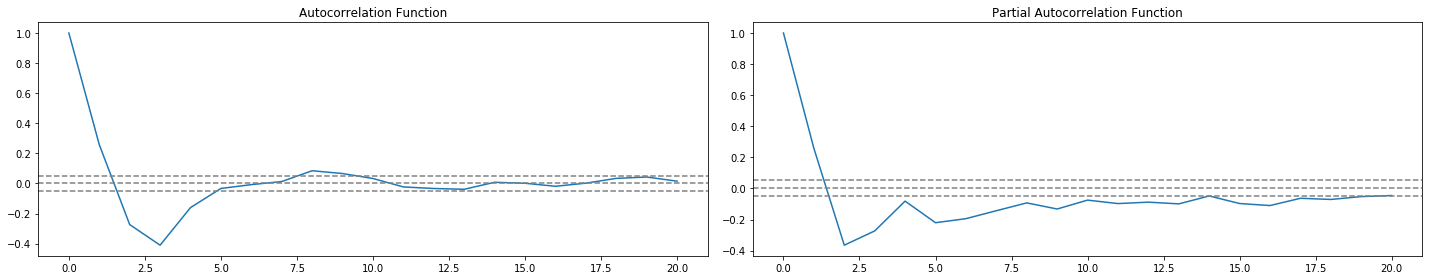

In [541]:
lag_acf = acf(residual_2007to2010, nlags=20)
lag_pacf = pacf(residual_2007to2010, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_2007to2010)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_2007to2010)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_2007to2010)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_2007to2010)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'RSS: 4025.5539')

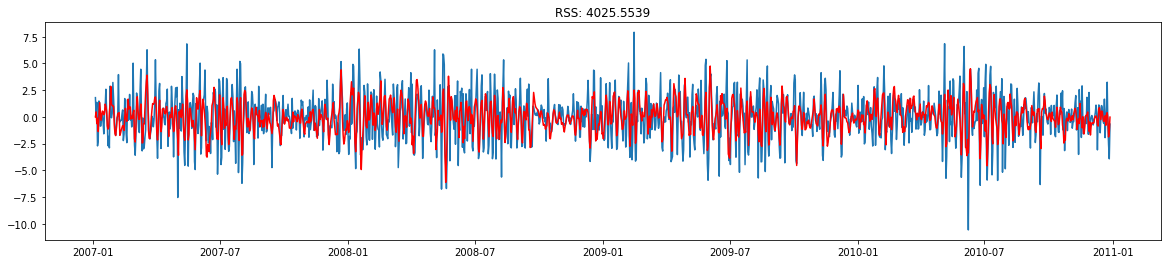

In [542]:
model_2007to2010 = ARIMA(residual_2007to2010, order=(2, 0, 2))  
results_ARMA_2007to2010 = model_2007to2010.fit(disp=-1)  
plt.plot(residual_2007to2010)
plt.plot(results_ARMA_2007to2010.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARMA_2007to2010.fittedvalues-residual_2007to2010.Temperature)**2))

Text(0.5, 1.0, 'RMSE: 1.6678')

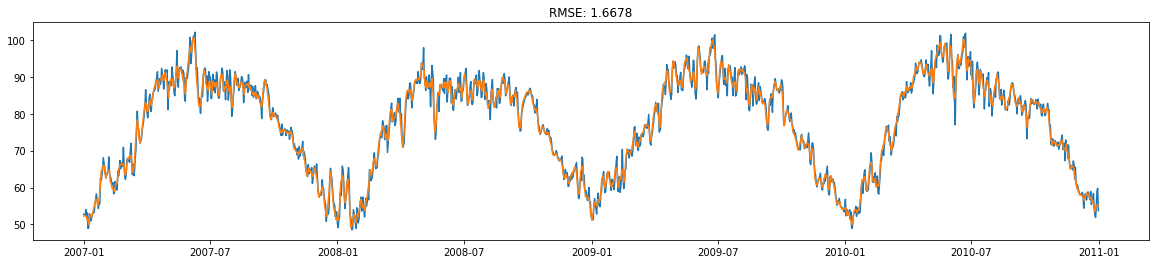

In [543]:
#Taking back the fitted values to the original scale 

predictions_ARMA_2007to2010 = pd.Series(results_ARMA_2007to2010.fittedvalues, copy=True)
# print(predictions_ARMA_2007to2010.head())
# print()
# print(predictions_ARMA_2007to2010.tail())

# print(len(dailyTempDataTS_2007to2010))
# print(len(trend_2007to2010))
# print(len(seasonal_2007to2010))
# print(len(predictions_ARMA))

dates_2007to2010 = dailyTempDataTS_2007to2010.index.values
myzeros_2007to2010 = np.zeros(len(dailyTempDataTS_2007to2010))
pred_ARMA_DF_2007to2010 = pd.DataFrame(myzeros_2007to2010,index=dates_2007to2010)

predictions_ARMA_new_2007to2010 = pd.merge(pred_ARMA_DF_2007to2010, pd.DataFrame(predictions_ARMA_2007to2010) , left_index=True, right_index= True,how='left').replace(np.NaN,0)
predictions_ARMA_new_2007to2010["value"] = predictions_ARMA_new_2007to2010['0_x'] + predictions_ARMA_new_2007to2010['0_y']
predictions_ARMA_new_2007to2010.drop(['0_x', '0_y'], inplace=True, axis=1)
#print(predictions_ARMA_new_2007to2010)


new_2007to2010 = pd.concat([predictions_ARMA_new_2007to2010,trend_2007to2010,seasonal_2007to2010], axis=1)
new_2007to2010.columns = ["Temp_res", "Temp_Trend", "Temp_Seas"]
new_2007to2010["Temp_Trend"] = new_2007to2010["Temp_Trend"].replace(np.nan,0)
new_2007to2010["Temp_Trend"][0:3] = new_2007to2010["Temp_Trend"][3]
new_2007to2010["Temp_Trend"][-3:] = new_2007to2010["Temp_Trend"][-4]
new_2007to2010["Temp"] = new_2007to2010["Temp_res"] + new_2007to2010["Temp_Trend"] + new_2007to2010["Temp_Seas"]
#print(new_2007to2010)



plt.plot(dailyTempDataTS_2007to2010)
plt.plot(new_2007to2010.Temp)
plt.title('RMSE: %.4f'% np.sqrt(sum((new_2007to2010.Temp-dailyTempDataTS_2007to2010.Temperature)**2)/len(dailyTempDataTS_2007to2010.Temperature)))

Repeting Step 4 and 5 for subset 2011_2014

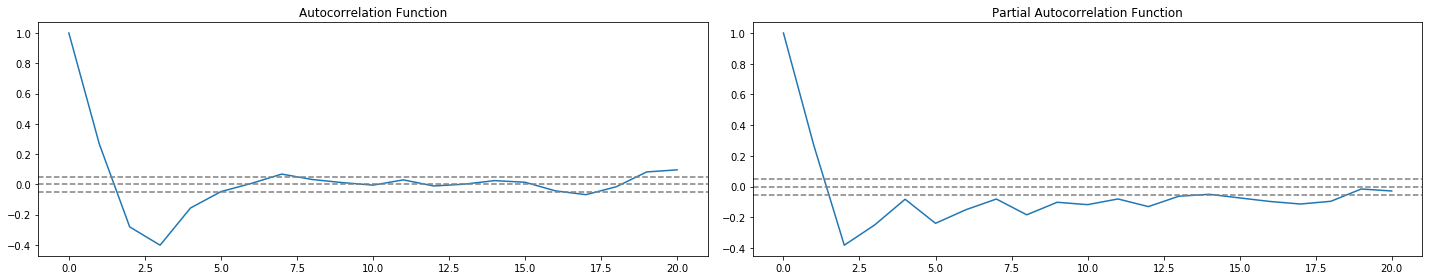

In [544]:
lag_acf = acf(residual_2011to2014, nlags=20)
lag_pacf = pacf(residual_2011to2014, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_2011to2014)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_2011to2014)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_2011to2014)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_2011to2014)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 3682.5154')

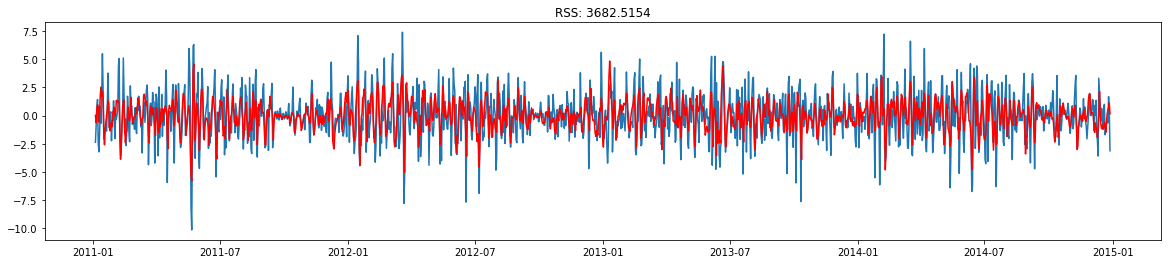

In [545]:
model_2011to2014 = ARIMA(residual_2011to2014, order=(2, 0, 2))  
results_ARMA_2011to2014 = model_2011to2014.fit(disp=-1)  
plt.plot(residual_2011to2014)
plt.plot(results_ARMA_2011to2014.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARMA_2011to2014.fittedvalues-residual_2011to2014.Temperature)**2))

Text(0.5, 1.0, 'RMSE: 1.5940')

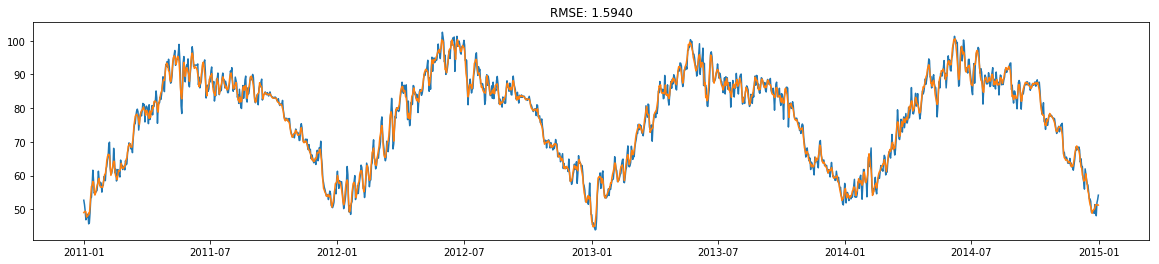

In [546]:
#Taking back the fitted values to the original scale 

predictions_ARMA_2011to2014 = pd.Series(results_ARMA_2011to2014.fittedvalues, copy=True)
# print(predictions_ARMA_2011to2014.head())
# print()
# print(predictions_ARMA_2011to2014.tail())

# print(len(dailyTempDataTS_2011to2014))
# print(len(trend_2011to2014))
# print(len(seasonal_2011to2014))
# print(len(predictions_ARMA))

dates_2011to2014 = dailyTempDataTS_2011to2014.index.values
myzeros_2011to2014 = np.zeros(len(dailyTempDataTS_2011to2014))
pred_ARMA_DF_2011to2014 = pd.DataFrame(myzeros_2011to2014,index=dates_2011to2014)

predictions_ARMA_new_2011to2014 = pd.merge(pred_ARMA_DF_2011to2014, pd.DataFrame(predictions_ARMA_2011to2014) , left_index=True, right_index= True,how='left').replace(np.NaN,0)
predictions_ARMA_new_2011to2014["value"] = predictions_ARMA_new_2011to2014['0_x'] + predictions_ARMA_new_2011to2014['0_y']
predictions_ARMA_new_2011to2014.drop(['0_x', '0_y'], inplace=True, axis=1)
#print(predictions_ARMA_new_2011to2014)


new_2011to2014 = pd.concat([predictions_ARMA_new_2011to2014,trend_2011to2014,seasonal_2011to2014], axis=1)
new_2011to2014.columns = ["Temp_res", "Temp_Trend", "Temp_Seas"]
new_2011to2014["Temp_Trend"] = new_2011to2014["Temp_Trend"].replace(np.nan,0)
new_2011to2014["Temp_Trend"][0:3] = new_2011to2014["Temp_Trend"][3]
new_2011to2014["Temp_Trend"][-3:] = new_2011to2014["Temp_Trend"][-4]
new_2011to2014["Temp"] = new_2011to2014["Temp_res"] + new_2011to2014["Temp_Trend"] + new_2011to2014["Temp_Seas"]
#print(new_2011to2014)



plt.plot(dailyTempDataTS_2011to2014)
plt.plot(new_2011to2014.Temp)
plt.title('RMSE: %.4f'% np.sqrt(sum((new_2011to2014.Temp-dailyTempDataTS_2011to2014.Temperature)**2)/len(dailyTempDataTS_2011to2014.Temperature)))

Repeting Step 4 and 5 for subset 2015_2018

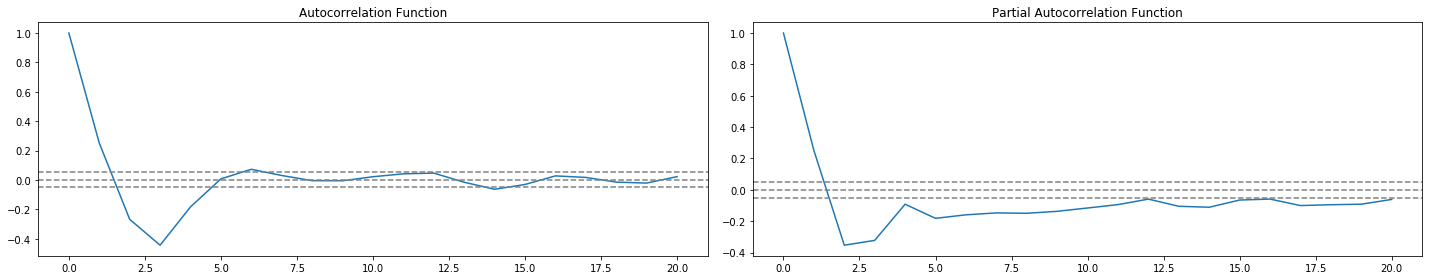

In [547]:
lag_acf = acf(residual_2015to2018, nlags=20)
lag_pacf = pacf(residual_2015to2018, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_2015to2018)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_2015to2018)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_2015to2018)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_2015to2018)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 4402.2848')

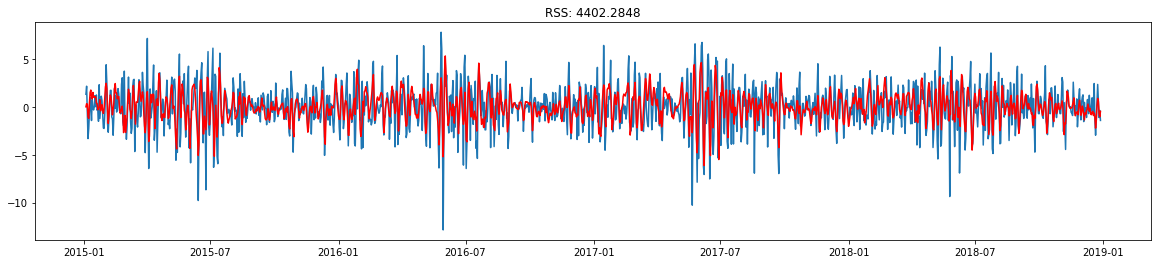

In [548]:
model_2015to2018 = ARIMA(residual_2015to2018, order=(2, 0, 2))  
results_ARMA_2015to2018 = model_2015to2018.fit(disp=-1)  
plt.plot(residual_2015to2018)
plt.plot(results_ARMA_2015to2018.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARMA_2015to2018.fittedvalues-residual_2015to2018.Temperature)**2))

Text(0.5, 1.0, 'RMSE: 1.7398')

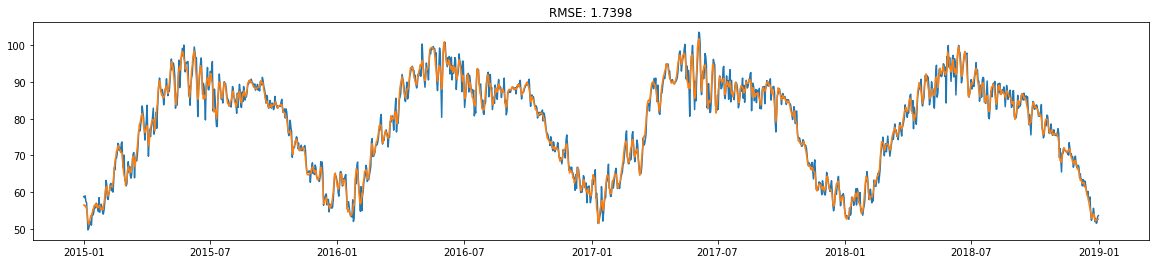

In [549]:
#Taking back the fitted values to the original scale 

predictions_ARMA_2015to2018 = pd.Series(results_ARMA_2015to2018.fittedvalues, copy=True)
# print(predictions_ARMA_2015to2018.head())
# print()
# print(predictions_ARMA_2015to2018.tail())

# print(len(dailyTempDataTS_2015to2018))
# print(len(trend_2015to2018))
# print(len(seasonal_2015to2018))
# print(len(predictions_ARMA))

dates_2015to2018 = dailyTempDataTS_2015to2018.index.values
myzeros_2015to2018 = np.zeros(len(dailyTempDataTS_2015to2018))
pred_ARMA_DF_2015to2018 = pd.DataFrame(myzeros_2015to2018,index=dates_2015to2018)

predictions_ARMA_new_2015to2018 = pd.merge(pred_ARMA_DF_2015to2018, pd.DataFrame(predictions_ARMA_2015to2018) , left_index=True, right_index= True,how='left').replace(np.NaN,0)
predictions_ARMA_new_2015to2018["value"] = predictions_ARMA_new_2015to2018['0_x'] + predictions_ARMA_new_2015to2018['0_y']
predictions_ARMA_new_2015to2018.drop(['0_x', '0_y'], inplace=True, axis=1)
#print(predictions_ARMA_new_2015to2018)


new_2015to2018 = pd.concat([predictions_ARMA_new_2015to2018,trend_2015to2018,seasonal_2015to2018], axis=1)
new_2015to2018.columns = ["Temp_res", "Temp_Trend", "Temp_Seas"]
new_2015to2018["Temp_Trend"] = new_2015to2018["Temp_Trend"].replace(np.nan,0)
new_2015to2018["Temp_Trend"][0:3] = new_2015to2018["Temp_Trend"][3]
new_2015to2018["Temp_Trend"][-3:] = new_2015to2018["Temp_Trend"][-4]
new_2015to2018["Temp"] = new_2015to2018["Temp_res"] + new_2015to2018["Temp_Trend"] + new_2015to2018["Temp_Seas"]
#print(new_2015to2018)



plt.plot(dailyTempDataTS_2015to2018)
plt.plot(new_2015to2018.Temp)
plt.title('RMSE: %.4f'% np.sqrt(sum((new_2015to2018.Temp-dailyTempDataTS_2015to2018.Temperature)**2)/len(dailyTempDataTS_2015to2018.Temperature)))

Text(0.5, 1.0, 'RMSE: 5.0494')

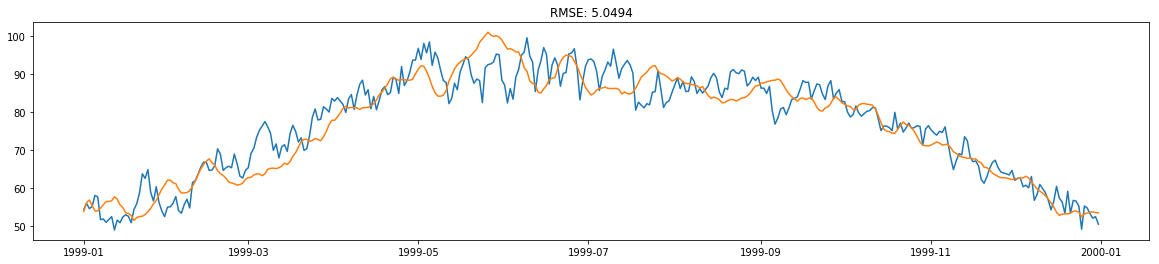

In [602]:
fCast_residuals_1999 = results_ARMA_1995to1998.forecast(steps=365)[0]
dates1999 = dailyTempDataTS_1999to2002["1999"].index.values

fCast1999 = pd.DataFrame(fCast_residuals_1999,index=dates1999)
fCast1999.columns = ["fCast_residuals_1999"]

# fCast_1999 = pd.concat([pd.DataFrame(fCast_residuals_1999),trend_1999,seasonal_1999], axis=1)
# trend_1995to1998_newDF = trend_1995to1998.reset_index()
new_1995to1998_noIndex = new_1995to1998.reset_index()
new_1995to1998_noIndex['Month'] = new_1995to1998_noIndex.Date.dt.month
new_1995to1998_noIndex['Day'] = new_1995to1998_noIndex.Date.dt.day
# print(new_1995to1998_noIndex.head())
mean_daily_new_1995to1998_noIndex = new_1995to1998_noIndex.groupby(['Month','Day']).mean().reset_index()
mean_daily_new_1995to1998_noIndex = mean_daily_new_1995to1998_noIndex[:-1]
# mean_daily_new_1995to1998_noIndex
fCast1999.reset_index(inplace=True)
fCast1999["Temp_Trend"] = new_1995to1998["1998"]["Temp_Trend"].reset_index()["Temp_Trend"]
fCast1999["Temp_Seas"] = new_1995to1998["1998"]["Temp_Seas"].reset_index()["Temp_Seas"]
fCast1999["Temp_pred"] = fCast1999["fCast_residuals_1999"] + fCast1999["Temp_Trend"] + fCast1999["Temp_Seas"]

fCast1999.set_index('index',inplace=True)
fCast1999
 
plt.plot(dailyTempDataTS_1999to2002["1999"])
plt.plot(fCast1999.Temp_pred)
plt.title('RMSE: %.4f'% np.sqrt(sum((fCast1999.Temp_pred-dailyTempDataTS_1999to2002["1999"].Temperature)**2)/len(dailyTempDataTS_1999to2002["1999"].Temperature)))

In [ ]:

stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())